## SPACE-GM Tutorial

This tutorial demonstrates the workflow of SPACE-GM, which contains the following steps:

1. Construct cellular graphs with raw inputs
2. Construct `CellularGraphDataset` and attach node-level / graph-level tasks
3. Initialize a Graph Neural Network (GNN) according to the prediction tasks
4. Train the GNN by randomly sampling subgraphs
5. Evaluate the GNN on node-level / graph-level tasks

In [1]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Found existing installation: torch_geometric 2.4.0
Uninstalling torch_geometric-2.4.0:
  Successfully uninstalled torch_geometric-2.4.0
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 53.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 40.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu117.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 42.6 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-cb18d8g2
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-cb18d8g2
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 8858f50dc6e91b71f7c489cf270945ffb539cae2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  P

In [2]:
import torch
torch.cuda.is_available()

False

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import spacegm

------------
### Step 1: Construct Cellular Graphs

We first construct cellular graphs as `networkx.Graph` using raw inputs including cell coordinates, cell types, biomarker expression, etc.

Raw files are assumed to be sorted in regions, each region should contain a spatially-continuous area of tissue and has all cells in the area identified and segmented.

For each region, we consider the following raw inputs:
- Cell coordinates stored in a csv file:
    - This file should contain at least two columns `X` and `Y` representing the 2D coordinates of cell centroids.
    - We highly recommend adding another column `CELL_ID` to match the rows with other raw inputs.
    - Example:
    | CELL_ID | X | Y |
    | --- | --- | --- |
    | 0 | 3 | 10 |
    | 1 | 25 | 12 |
    | 2 | 16 | 30 |
    | 3 | 32 | 26 |

- (Optional) Cell types stored in a csv file:
    - This file should contain at least one column other than `CELL_ID`, in which case this column will be treated as the cell type column. Otherwise, please explicitly name the cell type column as `CELL_TYPE`.
    - Example:
    | CELL_ID | CELL_TYPE |
    | --- | --- |
    | 0 | CD4 T cell |
    | 1 | CD8 T cell |
    | 2 | Tumor cell |
    | 3 | B cell |

- (Optional) Cell biomarker expression stored in a csv file:
    - This file should contain at least one column other than `CELL_ID`. All numeric columns in this file (other than `CELL_ID`) will be treated as biomarkers
    - Example (note that column `REGION_ID` will not be considered as a biomarker in this example):
    | CELL_ID | REGION_ID | BIOMARKER1 | BIOMARKER 2|
    | --- | --- | --- | --- |
    | 0 | region1 | 0.5 | 1.1 |
    | 1 | region1 | 0.8 | 2.3 |
    | 2 | region1 | 1.5 | 0.9 |
    | 3 | region1 | 5.5 | 0.1 |

- (Optional) Additional cell features stored in a csv file:
    - This file should contain at least one column other than `CELL_ID`. All numeric columns in this file (other than `CELL_ID`) will be treated as additional features for the cells
    - Example (column `SIZE` will be added as additional node attributes to the cellular graph):
    | CELL_ID | SIZE |
    | --- | --- |
    | 0 | 0.2 |
    | 1 | 0.5 |
    | 2 | 0.8 |
    | 3 | 0.1 |

- (Optional) Coordinates for the cell voronoi polygons:
    - Stored in a `json` or a `pickle` file. This file should contain a list of voronoi polygons enclosing cells.
    - Note that voronoi polygons can be calculated on-the-fly based on cell coordinates.
    - Example of content:
        ```text
        [array([[22.5, 22. ],
                [32.3, 17.1],
                [32.3, 12.5],
                [32.3, 0.  ],
                [18.8, 0.  ],
                [15.,  0.  ],
                [13.4, 17.5],
                [22.5, 22. ]]),
         array([[ 0. , 28.9],
                [ 0. , 30.3],
                [ 7.8, 30.3],
                [24.6, 30.3],
                [22.5, 22. ],
                [13.4, 17.5],
                [ 0. , 26.2],
                [ 0. , 28.9]]),
         array([[ 0. , 26.2],
                [13.4, 17.5],
                [15. ,  0. ],
                [12.3,  0. ],
                [ 0. ,  0. ],
                [ 0. , 18.8],
                [ 0. , 26.2]]),
         array([[24.6, 30.3],
                [28.2, 30.3],
                [32.3, 30.3],
                [32.3, 25.1],
                [32.3, 17.1],
                [22.5, 22. ],
                [24.6, 30.3]])]
        ```

Additionally, to train models for graph-level (region-level) tasks, a separate csv file is required to provide the labels:
- Labels for graph-level tasks:
    - The first column of this file must be `REGION_ID`: identifiers for regions in the dataset. This column will be used as the index for graph labels stored in `spacegm.inference.AddGraphLabel`.
    - The following columns store labels for graph-level tasks, with task names as column names.
    - Example:

    | REGION_ID | GRAPH_TASK1 | GRAPH_TASK 2|
    | --- | --- | --- |
    | region 1 | 0 | 1 |
    | region 2 | 0 | 0 |
    | region 3 | 1 | 1 |

<br/><br/><br/><br/>
We provided some example files under `data/voronoi`:

In [2]:
from spacegm.graph_build import load_cell_coords, load_cell_types, load_cell_biomarker_expression, load_cell_features
region_id = "df_0_1_1"
cell_coords_file = '/juno/work/shah/users/ibrahih3/codebase/space-gm/data_melanoma/df_0_1_1_coords.csv'
cell_types_file = '/juno/work/shah/users/ibrahih3/codebase/space-gm/data_melanoma/df_0_1_1_cell_types.csv'
cell_biomarker_expression_file = '/juno/work/shah/users/ibrahih3/codebase/space-gm/data_melanoma/df_0_1_1_expression.csv'

graph_label_file = '/juno/work/shah/users/ibrahih3/codebase/space-gm/data_melanoma_label/graph_label.csv'

print("\nInputs for region %s:" % region_id)
print("\nCell coordinates")
display(load_cell_coords(cell_coords_file))
print("\nCell types")
display(load_cell_types(cell_types_file))
print("\nCell biomarker expression")
display(load_cell_biomarker_expression(cell_biomarker_expression_file))

print("\nGraph-level tasks")
display(pd.read_csv(graph_label_file))


Inputs for region df_0_1_1:

Cell coordinates


,CELL_ID,X,Y
0,000833cf8d5424a3,1491.077,-554.942
1,002287d8a57a5200,799.890,-635.517
2,00295b12f4ecf52c,683.569,-815.126
3,0030dccd41cea232,743.927,-826.846
4,003e872c6378b64d,1436.872,-507.476
...,...,...,...
4778,ffd09d368e8875c4,1302.678,-934.377
4779,ffd53d1c5a8557e0,368.887,-225.610
4780,ffd7349c499c603c,660.715,-711.990
4781,fffb80be576ffb89,488.431,-653.683



Cell types


,CELL_ID,CELL_TYPE
0,000833cf8d5424a3,Tconv8
1,002287d8a57a5200,Tumor
2,00295b12f4ecf52c,Adipo_Lang
3,0030dccd41cea232,Tumor
4,003e872c6378b64d,Tumor
...,...,...
4778,ffd09d368e8875c4,Tumor
4779,ffd53d1c5a8557e0,Unknown
4780,ffd7349c499c603c,Tumor
4781,fffb80be576ffb89,MHCIIneg_macro



Cell biomarker expression


,CELL_ID,BM-B2M,BM-B7H3,BM-CD14,BM-CD163,BM-CD20,BM-CD25,BM-CD27,BM-CD3,BM-CD4,...,BM-LAG3,BM-MHCI,BM-MHCII,BM-MRC1,BM-PD1,BM-PDL1,BM-S100B,BM-SOX10,BM-TGM2,BM-TIM3
0,000833cf8d5424a3,24.95520,8.08955,8.560791,13.331108,0.000000,5.554052,2.006756,36.304056,0.797297,...,2.959459,99.3433,27.750005,13.749991,0.878378,0.268657,49.119400,5.90123,0.378378,29.10450
1,002287d8a57a5200,10.49400,14.07230,0.516980,0.000000,0.000000,0.109434,0.505661,0.400000,0.003774,...,0.162264,64.2048,0.011321,6.358492,0.041509,0.060241,36.905656,21.65930,0.086792,7.79518
2,00295b12f4ecf52c,4.06250,11.76790,0.451087,0.000000,0.000000,0.076087,0.043478,0.366848,0.000000,...,0.347826,28.9911,0.054348,4.875000,0.029891,0.017857,36.100544,10.55860,0.054348,4.05357
3,0030dccd41cea232,5.11429,13.38570,1.038961,0.000000,0.000000,0.629870,0.285714,0.324675,0.000000,...,0.662337,37.6857,0.000000,4.681816,0.110389,0.014286,42.428600,26.94050,0.045455,4.04286
4,003e872c6378b64d,8.45139,4.13889,3.925677,0.594594,0.000000,3.618241,0.398648,1.260136,0.060811,...,0.179054,49.2222,5.337835,7.489865,0.189189,0.090278,81.212877,15.37500,0.435811,9.60417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4778,ffd09d368e8875c4,2.87097,6.32258,2.960265,0.000000,0.000000,0.364239,0.278146,1.139070,0.000000,...,1.039735,35.6774,0.000000,5.132453,0.079470,0.032258,152.397361,25.59170,0.013245,5.19355
4779,ffd53d1c5a8557e0,18.30490,5.80488,3.475002,1.325002,0.000000,5.062486,0.225000,0.156250,0.131250,...,0.018750,28.7317,0.362500,8.282050,0.225000,0.048780,1.137501,4.39744,2.318748,27.71950
4780,ffd7349c499c603c,17.07280,20.09930,1.673610,0.002315,0.000000,0.300926,1.645833,0.347222,0.046296,...,0.196759,82.9735,4.733798,6.650461,0.053241,0.066225,26.099300,12.43770,0.233797,9.77483
4781,fffb80be576ffb89,13.46700,10.02830,8.014397,8.679015,0.010288,0.514403,0.927981,7.921814,2.179250,...,0.006173,34.8396,10.932071,35.989664,0.158436,0.216981,10.133750,4.09489,0.829220,23.21700



Graph-level tasks


,REGION_ID,RESPONSE_ABBREV
0,df_1_2_8,0
1,df_6_3_1,1
2,df_4_3_18,1
3,df_3_2_23,0
4,df_6_2_2,1
...,...,...
310,df_2_1_4,0
311,df_1_2_19,0
312,df_4_3_19,1
313,df_2_2_8,0


<br/><br/><br/><br/>

A networkx graph can be constructed using the inputs above

In [12]:
# sample_df = load_cell_biomarker_expression(cell_biomarker_expression_file)
intensities = list(sample_df.columns[1:])
len(intensities)

26

In [3]:
import os
path = "../data_bodenmiller/data_bodenmiller/basel_data"
# os.listdir(path)

In [8]:
def calcualte_voronoi_from_coords(x, y, region_id, xmax=None, ymax=None, xmin=None, ymin=None):
    """Calculate voronoi polygons from a set of points

    Points are assumed to have coordinates in ([0, xmax], [0, ymax])

    Args:
        x (array-like): x coordinates of points
        y (array-like): y coordinates of points
        xmax (float): maximum x coordinate
        ymax (float): maximum y coordinate
        (added by me to accomodate for the negative coordinates in the melanoma dataset)
        xmin (float): minimum x coordinate
        ymin (float): minimum y coordinate

    Returns:
        voronoi_polygons (list): list of voronoi polygons,
            represented by the coordinates of their exterior vertices
    """
    from geovoronoi import voronoi_regions_from_coords
    from shapely import geometry
    import json
    import os
    from pathlib import Path
    
    xmin = 1.01 * min(x) if xmin is None else xmin
    ymin = 1.01 * min(y) if ymin is None else ymin
    xmax = 1.01 * max(x) if xmax is None else xmax
    ymax = 1.01 * max(y) if ymax is None else ymax
    boundary = geometry.Polygon([[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]])

    coords = np.stack([
        np.array(x).reshape((-1,)),
        np.array(y).reshape((-1,))], 1)
    region_polys, _ = voronoi_regions_from_coords(coords, boundary)
    voronoi_polygons = [list(map(list, region_polys[k].exterior.coords)) for k in region_polys]
    
    # Define the directory and filename
    dir_path = Path(os.getcwd()).parent / '/juno/work/shah/users/ibrahih3/codebase/space-gm/data_melanoma'
    file_path = dir_path / f'{region_id}.json'

    # Create the directory if it does not exist
    os.makedirs(dir_path, exist_ok=True)

    # Write polygons to a JSON file
    with open(file_path, 'w') as f:
        json.dump(voronoi_polygons, f)
    
    return voronoi_polygons



In [7]:
# cell_coords_file = '../data_melanoma/df_0_1_1_coords.csv'
cell_coords = load_cell_coords(cell_coords_file)
# cell_coords

x = cell_coords['X']
y = cell_coords['Y']
voronoi_polygons_sp = calcualte_voronoi_from_coords(x, y, 'df_0_1_1')

# voronoi_polygons_sp

In [8]:
# Try creating a nx graph for one of the regions

print("Constructing nx graph for region %s" % region_id)
G = spacegm.construct_graph_for_region(
    region_id,
    cell_coords_file=cell_coords_file,
    cell_types_file=cell_types_file,
    cell_biomarker_expression_file=cell_biomarker_expression_file,
    voronoi_file='/juno/work/shah/users/ibrahih3/codebase/space-gm/data_melanoma/df_0_1_1.json')
    # cell_features_file=cell_features_file)
print(G)

print("Information stored in a node:")
print(G.nodes[0])

Constructing nx graph for region df_0_1_1
Graph with 4780 nodes and 14170 edges
Information stored in a node:
{'voronoi_polygon': array([[  69.62583645, -583.19048598],
       [ 118.01454477, -671.64296356],
       [  10.94941   , -701.54147194],
       [  10.94941   , -561.85360364],
       [  69.62583645, -583.19048598]]), 'cell_id': '2556cac7f6b7138c', 'center_coord': (33.695, -635.81), 'cell_type': 'Unknown', 'biomarker_expression': {'B2M': 8.10345, 'B7H3': 2.50862, 'CD14': 2.40815964555698, 'CD163': 0.0051020376222929, 'CD20': 0.0, 'CD25': 3.05612469842925, 'CD27': 0.0255102199062188, 'CD3': 0.0051020376222929, 'CD4': 0.0, 'CD45': 0.0051020376222929, 'CD56': 1.28571434134753, 'CD68': 0.0517241, 'CD8': 0.0775862, 'FOXP3': 0.0, 'IDO1': 0.0, 'KI67': 4.3875, 'LAG3': 0.0, 'MHCI': 12.0603, 'MHCII': 0.0, 'MRC1': 4.87245183821257, 'PD1': 0.0, 'PDL1': 0.00862069, 'S100B': 2.33163192006311, 'SOX10': 2.6625, 'TGM2': 3.4234679979972, 'TIM3': 13.931}}


<br/><br/><br/><br/>
Then we process all four regions from the example files and store the nx graphs into a dataset folder

In [9]:
raw_data_root = "/juno/work/shah/users/ibrahih3/codebase/space-gm/data_melanoma"

dataset_root = "/juno/work/shah/users/ibrahih3/codebase/space-gm/example_data_melanoma"
nx_graph_root = os.path.join(dataset_root, "graph")
fig_save_root = os.path.join(dataset_root, "fig")
model_save_root = os.path.join(dataset_root, 'model')

os.makedirs(nx_graph_root, exist_ok=True)
os.makedirs(fig_save_root, exist_ok=True)
os.makedirs(model_save_root, exist_ok=True)

# region_ids = [
#     'df_0_1_1',
#     'UPMC_c001_v001_r001_reg004',
#     'UPMC_c001_v001_r001_reg009',
#     'UPMC_c001_v001_r001_reg014',
# ]




region_ids = ['df_1_2_8',
 'df_6_3_1',
 'df_4_3_18',
 'df_3_2_23',
 'df_6_2_2',
 'df_4_2_10',
 'df_3_1_17',
 'df_5_2_1',
 'df_6_4_12',
 'df_6_2_9',
 'df_1_2_10',
 'df_5_1_3',
 'df_6_4_5',
 'df_0_2_17',
 'df_6_4_9',
 'df_6_3_7',
 'df_1_1_6',
 'df_0_2_14',
 'df_3_1_16',
 'df_0_2_13',
 'df_1_2_27',
 'df_1_2_6',
 'df_0_1_17',
 'df_3_2_33',
 'df_6_1_3',
 'df_2_4_22',
 'df_4_2_9',
 'df_1_1_8',
 'df_3_1_30',
 'df_2_1_2',
 'df_2_2_17',
 'df_2_4_33',
 'df_2_2_20',
 'df_1_3_3',
 'df_1_1_9',
 'df_4_5_3',
 'df_3_1_31',
 'df_1_2_29',
 'df_3_1_14',
 'df_2_2_2',
 'df_4_3_23',
 'df_3_2_15',
 'df_3_2_21',
 'df_2_2_3',
 'df_3_2_14',
 'df_4_5_2',
 'df_0_3_6',
 'df_0_3_21',
 'df_6_1_8',
 'df_0_2_12',
 'df_6_4_6',
 'df_3_1_22',
 'df_0_2_11',
 'df_4_4_2',
 'df_3_1_8',
 'df_3_2_31',
 'df_5_1_1',
 'df_4_2_4',
 'df_4_3_24',
 'df_4_1_2',
 'df_4_3_2',
 'df_0_1_10',
 'df_6_4_2',
 'df_4_2_3',
 'df_0_3_15',
 'df_0_1_8',
 'df_3_1_13',
 'df_4_2_7',
 'df_4_2_6',
 'df_3_1_7',
 'df_4_5_4',
 'df_3_2_20',
 'df_3_2_11',
 'df_2_1_7',
 'df_0_2_22',
 'df_2_2_11',
 'df_0_1_1',
 'df_6_1_4',
 'df_2_4_35',
 'df_4_3_14',
 'df_6_4_7',
 'df_6_1_6',
 'df_3_1_11',
 'df_4_3_1',
 'df_2_1_8',
 'df_6_3_6',
 'df_2_4_14',
 'df_4_4_3',
 'df_3_2_7',
 'df_1_2_14',
 'df_4_5_9',
 'df_4_5_10',
 'df_1_2_7',
 'df_6_3_2',
 'df_3_2_10',
 'df_2_4_6',
 'df_2_4_34',
 'df_2_4_3',
 'df_1_3_13',
 'df_2_4_2',
 'df_2_2_15',
 'df_1_2_4',
 'df_3_1_3',
 'df_0_2_29',
 'df_3_2_12',
 'df_4_5_7',
 'df_1_2_3',
 'df_3_2_3',
 'df_3_2_4',
 'df_0_2_18',
 'df_6_4_3',
 'df_0_3_10',
 'df_4_1_5',
 'df_6_3_5',
 'df_0_2_23',
 'df_6_2_7',
 'df_4_2_2',
 'df_2_2_19',
 'df_2_2_14',
 'df_3_1_35',
 'df_2_4_37',
 'df_4_4_14',
 'df_2_1_3',
 'df_1_2_2',
 'df_2_2_7',
 'df_4_4_19',
 'df_1_2_20',
 'df_6_4_4',
 'df_0_2_16',
 'df_3_1_21',
 'df_3_2_26',
 'df_1_2_15',
 'df_2_1_17',
 'df_0_1_15',
 'df_3_2_16',
 'df_3_2_5',
 'df_1_3_4',
 'df_3_2_17',
 'df_1_3_10',
 'df_0_3_9',
 'df_1_3_8',
 'df_4_1_1',
 'df_0_2_4',
 'df_3_1_4',
 'df_4_5_11',
 'df_0_2_5',
 'df_0_3_18',
 'df_3_1_28',
 'df_2_2_6',
 'df_4_3_13',
 'df_2_1_1',
 'df_2_1_11',
 'df_2_2_4',
 'df_3_1_26',
 'df_6_4_10',
 'df_1_3_5',
 'df_0_3_14',
 'df_0_1_16',
 'df_0_2_24',
 'df_1_1_7',
 'df_1_3_11',
 'df_6_1_5',
 'df_2_4_36',
 'df_2_1_15',
 'df_0_3_1',
 'df_2_4_9',
 'df_3_2_6',
 'df_1_1_5',
 'df_3_1_5',
 'df_3_2_25',
 'df_4_5_6',
 'df_6_2_6',
 'df_3_2_13',
 'df_4_2_8',
 'df_4_3_4',
 'df_0_1_6',
 'df_6_3_4',
 'df_0_1_4',
 'df_3_1_27',
 'df_3_2_30',
 'df_0_3_5',
 'df_3_1_32',
 'df_3_1_9',
 'df_0_2_30',
 'df_3_1_15',
 'df_1_3_2',
 'df_2_2_16',
 'df_0_1_25',
 'df_6_3_3',
 'df_1_2_24',
 'df_3_2_2',
 'df_6_1_2',
 'df_5_1_2',
 'df_1_2_26',
 'df_3_2_1',
 'df_5_1_4',
 'df_4_5_12',
 'df_6_1_1',
 'df_4_4_11',
 'df_4_3_20',
 'df_0_2_3',
 'df_6_4_11',
 'df_1_2_25',
 'df_0_3_12',
 'df_0_3_16',
 'df_0_3_19',
 'df_2_2_9',
 'df_3_1_33',
 'df_4_4_1',
 'df_0_3_17',
 'df_0_1_9',
 'df_2_2_18',
 'df_0_1_3',
 'df_0_3_22',
 'df_3_2_28',
 'df_3_1_10',
 'df_3_2_27',
 'df_0_2_27',
 'df_3_1_34',
 'df_1_1_1',
 'df_6_4_1',
 'df_3_1_6',
 'df_1_2_1',
 'df_2_1_6',
 'df_1_2_16',
 'df_2_4_30',
 'df_0_2_20',
 'df_0_2_19',
 'df_6_2_3',
 'df_1_2_5',
 'df_3_1_1',
 'df_0_3_3',
 'df_2_1_16',
 'df_1_1_3',
 'df_2_4_32',
 'df_0_3_8',
 'df_2_4_7',
 'df_3_1_20',
 'df_0_3_4',
 'df_2_4_4',
 'df_1_2_17',
 'df_4_1_4',
 'df_5_2_4',
 'df_6_4_13',
 'df_2_1_10',
 'df_3_2_32',
 'df_4_5_13',
 'df_4_2_11',
 'df_4_5_15',
 'df_1_1_2',
 'df_2_4_5',
 'df_3_2_29',
 'df_6_2_5',
 'df_2_1_9',
 'df_3_2_18',
 'df_3_1_18',
 'df_5_2_2',
 'df_4_5_8',
 'df_4_2_1',
 'df_2_4_23',
 'df_2_4_8',
 'df_3_1_2',
 'df_3_1_29',
 'df_0_3_20',
 'df_4_3_11',
 'df_5_2_3',
 'df_1_3_1',
 'df_1_2_9',
 'df_6_1_7',
 'df_0_3_13',
 'df_0_2_21',
 'df_2_2_10',
 'df_1_3_7',
 'df_4_3_3',
 'df_3_1_19',
 'df_0_2_28',
 'df_3_2_19',
 'df_6_2_10',
 'df_3_2_22',
 'df_3_1_12',
 'df_4_1_3',
 'df_0_3_2',
 'df_2_1_5',
 'df_1_3_6',
 'df_0_2_1',
 'df_6_2_1',
 'df_0_3_7',
 'df_1_1_4',
 'df_3_2_9',
 'df_3_2_8',
 'df_4_3_16',
 'df_4_5_5',
 'df_3_2_24',
 'df_2_2_1',
 'df_4_3_9',
 'df_3_1_23',
 'df_1_3_12',
 'df_1_3_9',
 'df_6_4_8',
 'df_0_1_7',
 'df_0_2_26',
 'df_4_5_14',
 'df_2_4_1',
 'df_4_3_17',
 'df_2_4_15',
 'df_6_2_4',
 'df_4_4_5',
 'df_4_3_15',
 'df_1_2_18',
 'df_4_2_5',
 'df_1_2_13',
 'df_4_4_17',
 'df_2_4_31',
 'df_2_1_4',
 'df_1_2_19',
 'df_4_3_19',
 'df_2_2_8',
 'df_4_1_6']


In [5]:
from tqdm import tqdm

for region_id in tqdm(region_ids):
    print("Processing %s" % region_id)
    cell_coords_file = os.path.join(raw_data_root, "%s_coords.csv" % region_id)
    cell_types_file = os.path.join(raw_data_root, "%s_cell_types.csv" % region_id)
    cell_biomarker_expression_file = os.path.join(raw_data_root, "%s_expression.csv" % region_id)
    # cell_features_file = os.path.join(raw_data_root, "%s.cell_features.csv" % region_id)
    voronoi_file = os.path.join(raw_data_root, "%s.json" % region_id)

    voronoi_polygon_img_output = os.path.join(fig_save_root, "%s_voronoi.png" % region_id)
    graph_img_output = os.path.join(fig_save_root, "%s_graph.png" % region_id)
    graph_output = os.path.join(nx_graph_root, "%s.gpkl" % region_id)

    if not os.path.exists(graph_output):
        G = spacegm.construct_graph_for_region(
            region_id,
            cell_coords_file=cell_coords_file,
            cell_types_file=cell_types_file,
            cell_biomarker_expression_file=cell_biomarker_expression_file,
            # cell_features_file=cell_features_file,
            voronoi_file=voronoi_file,
            graph_output=graph_output,
            voronoi_polygon_img_output=voronoi_polygon_img_output,
            graph_img_output=graph_img_output,
            figsize=10)

plt.close()
print("Finished!")

 50%|█████     | 160/318 [00:00<00:00, 1598.21it/s]Processing df_1_2_8
Processing df_6_3_1
Processing df_4_3_18
Processing df_3_2_23
Processing df_6_2_2
Processing df_4_2_10
Processing df_3_1_17
Processing df_5_2_1
Processing df_6_4_12
Processing df_6_2_9
Processing df_1_2_10
Processing df_5_1_3
Processing df_6_4_5
Processing df_0_2_17
Processing df_6_4_9
Processing df_6_3_7
Processing df_1_1_6
Processing df_0_2_14
Processing df_3_1_16
Processing df_0_2_13
Processing df_1_2_27
Processing df_1_2_6
Processing df_0_1_17
Processing df_3_2_33
Processing df_6_1_3
Processing df_2_4_22
Processing df_4_2_9
Processing df_1_1_8
Processing df_3_1_30
Processing df_2_1_2
Processing df_2_2_17
Processing df_2_4_33
Processing df_2_2_20
Processing df_1_3_3
Processing df_1_1_9
Processing df_4_5_3
Processing df_3_1_31
Processing df_1_2_29
Processing df_3_1_14
Processing df_2_2_2
Processing df_4_3_23
Processing df_3_2_15
Processing df_3_2_21
Processing df_2_2_3
Processing df_3_2_14
Processing df_4_5_2
Proc

<br/><br/><br/><br/>

The function `spacegm.construct_graph_for_region` also generates some visualizations for each region, stored under `graph_img_output` and `voronoi_polygon_img_output`.

Here is an example:

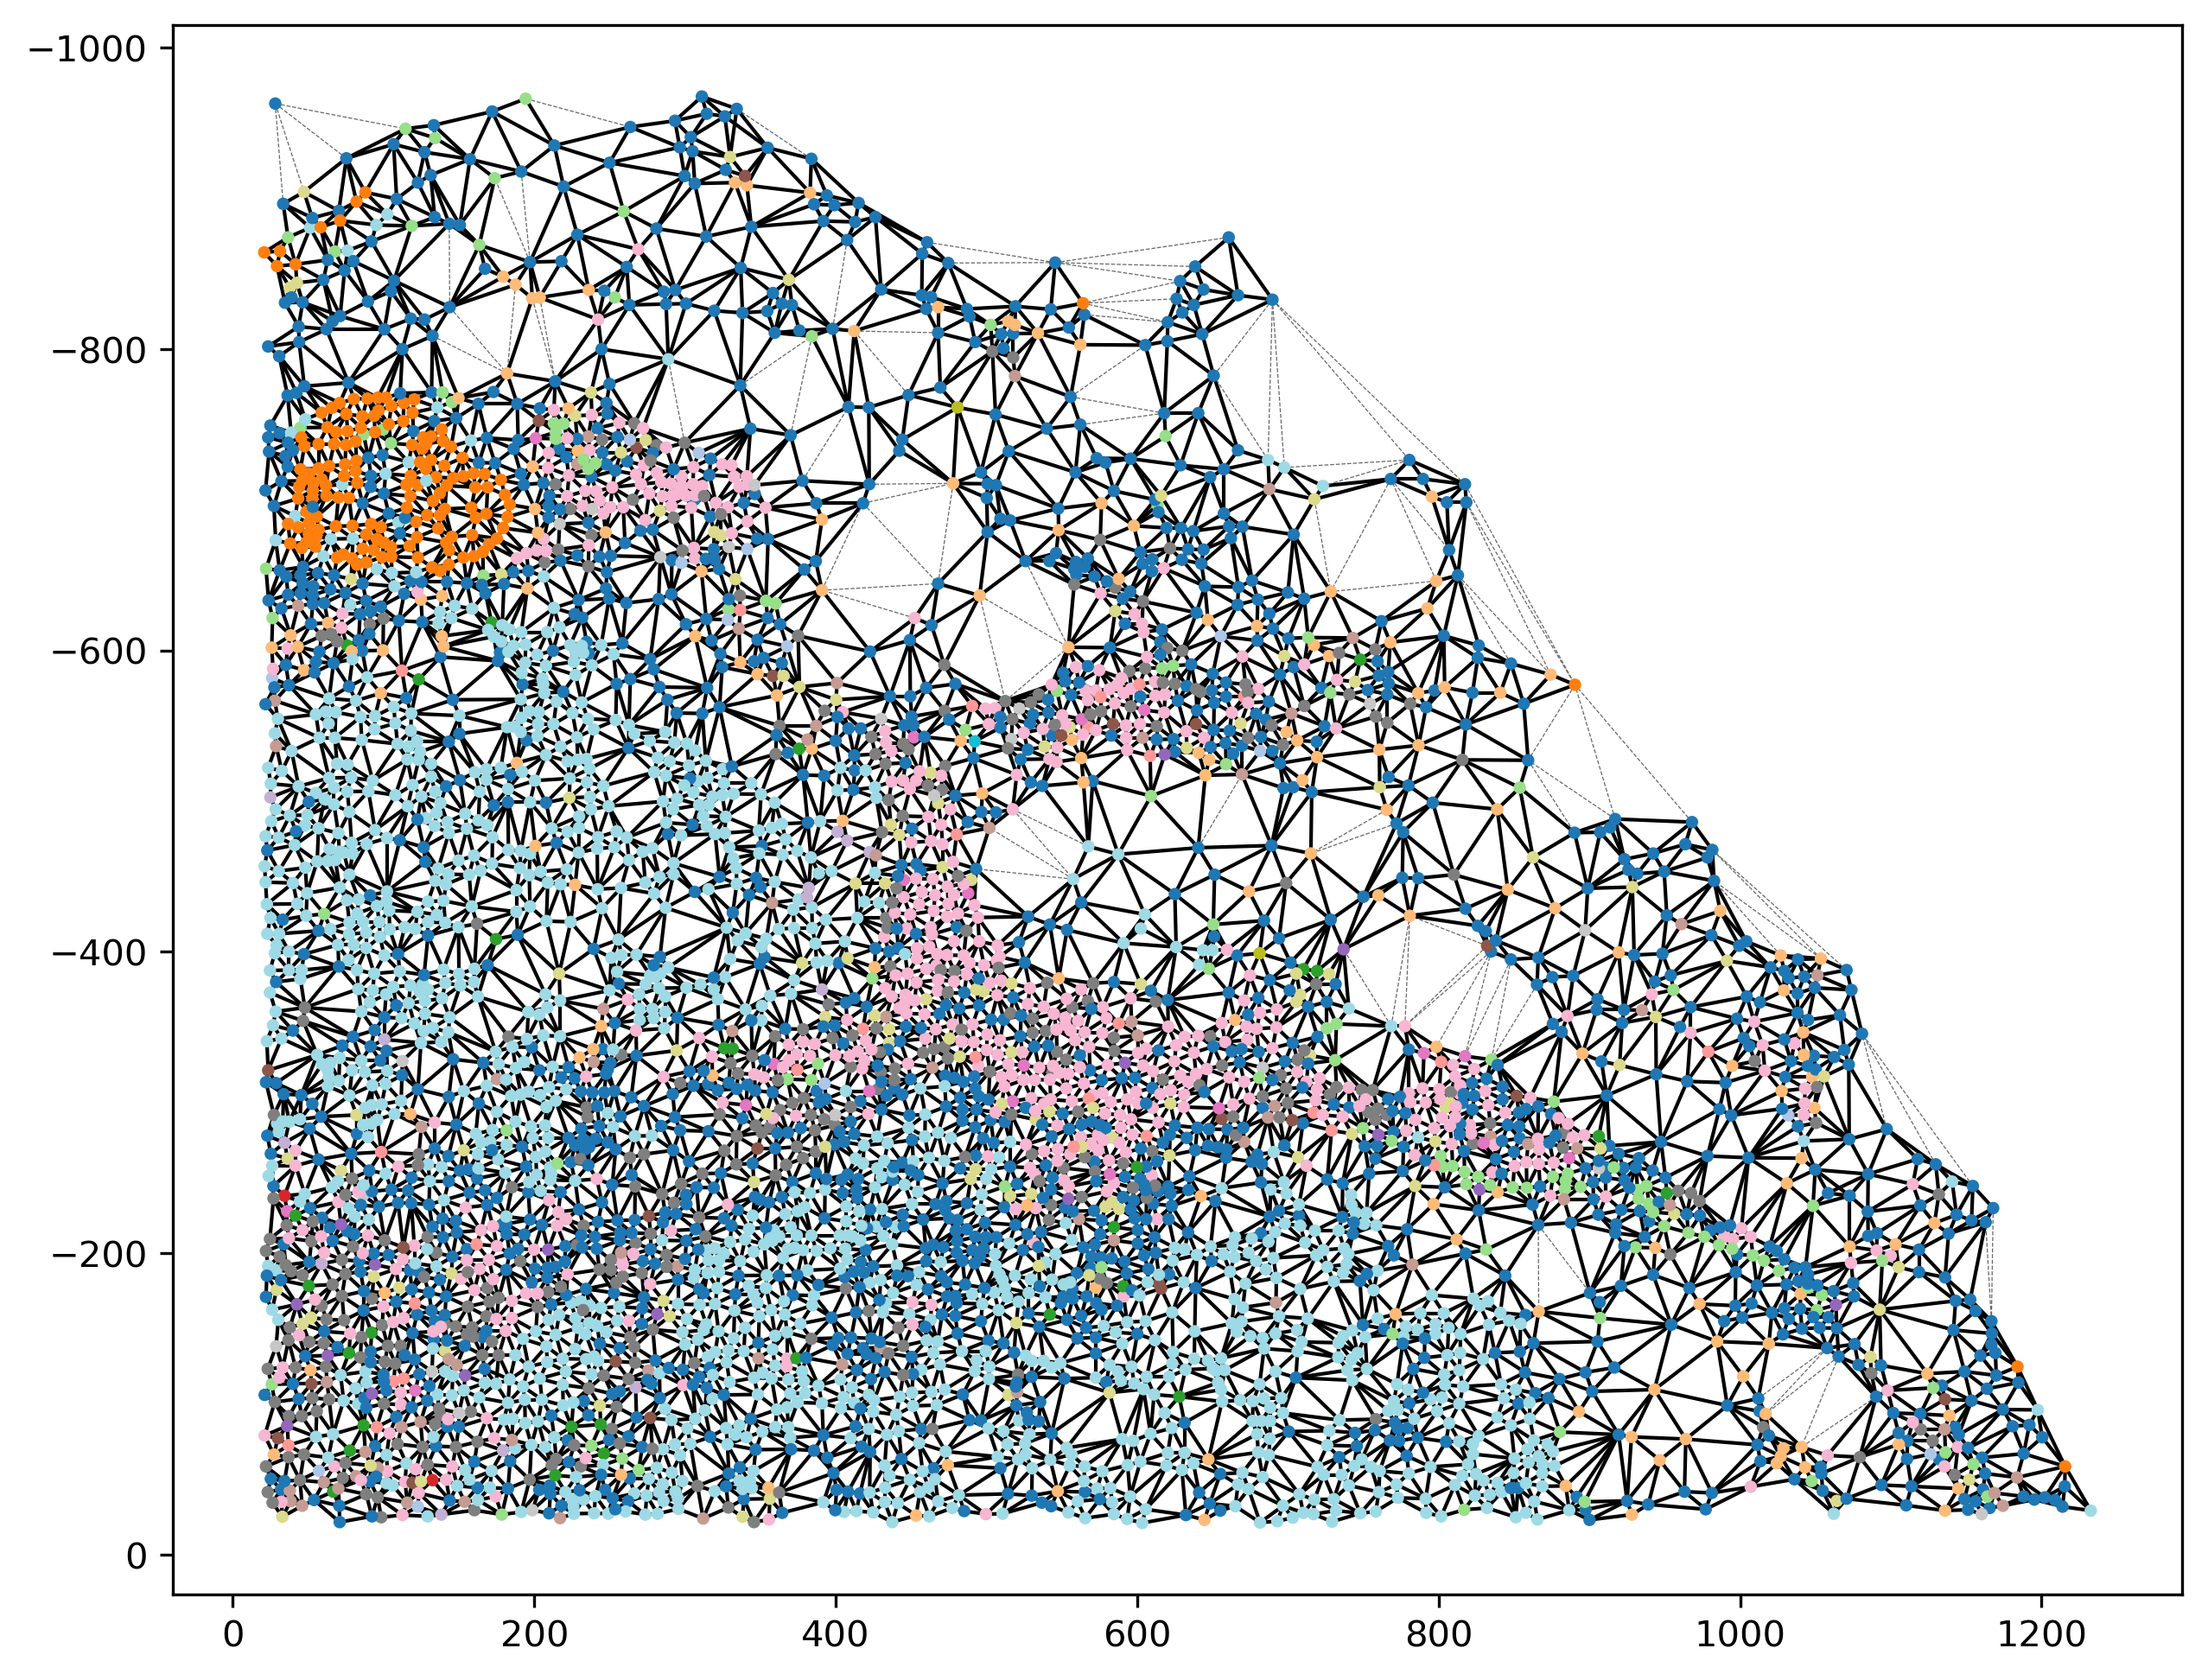

In [18]:
from IPython.display import Image 
pil_img = Image(filename=graph_img_output)
display(pil_img)

<br/><br/><br/><br/>

------------
### Step 2: Construct `CellularGraphDataset`

`CellularGraphDataset` will be the major data container used in model training and evaluation. This object also handles all the featurization, subgraph sampling, and other necessary functionalities for SPACE-GM.

We previously saved all regions as networkx graphs, now we initialize the dataset object using these graph files

In [10]:
dataset_root = "/juno/work/shah/users/ibrahih3/codebase/space-gm/example_data_melanoma"
dataset_kwargs = {
    'transform': [],
    'pre_transform': None,
    'raw_folder_name': 'graph',  # os.path.join(dataset_root, "graph") is the folder where we saved nx graphs
    'processed_folder_name': 'tg_graph',  # processed dataset files will be stored here
    'node_features': ["cell_type" , "biomarker_expression", "neighborhood_composition","center_coord"],  # There are all the cellular features that we want the dataset to compute
    'edge_features': ["edge_type", "distance"],  # edge (cell pair) features
    'subgraph_size': 3,  # indicating we want to sample 3-hop subgraphs from these regions (for training/inference), this is a core parameter for SPACE-GM.
    'subgraph_source': 'on-the-fly',
    'subgraph_allow_distant_edge': True,
    'subgraph_radius_limit': 200.,
}

feature_kwargs = {
    "biomarker_expression_process_method": "linear",
    "biomarker_expression_lower_bound": 0,
    "biomarker_expression_upper_bound": 18,
    "neighborhood_size": 10,
}
dataset_kwargs.update(feature_kwargs)

dataset = spacegm.CellularGraphDataset(dataset_root, **dataset_kwargs)

<br/><br/><br/><br/>

The full cellular graph for each region in the dataset can be accessed using the class method `get_full`:

In [13]:
i = 0
dataset.get_full(i)

Data(x=[4780, 50], edge_index=[2, 28340], edge_attr=[28340, 2], num_nodes=4780, region_id='df_0_1_1', component_id=0)

<br/><br/><br/><br/>

And the n-hop (n=3 in this example) subgraph of region `i` around its center node `j` can be accessed using the class method `get_subgraph`: 

In [14]:
i = 0
j = 1234
dataset.get_subgraph(i, j)

Data(x=[32, 50], edge_index=[2, 156], edge_attr=[156, 2], center_node_index=21, original_center_node=1234, num_nodes=32, region_id='df_0_1_1', component_id=0)

<br/><br/><br/><br/>

By default, indexing the dataset object will yield an n-hop subgraph around a randomly picked center node (see class method `pick_center`) in the specified region:

In [15]:
dataset[0]

Data(x=[45, 50], edge_index=[2, 226], edge_attr=[226, 2], center_node_index=12, original_center_node=1376, num_nodes=45, region_id='df_0_1_1', component_id=0)

<br/><br/><br/><br/>

There is also a quick plotting functions for subgraphs: `plot_subgraph`

(673.7535, 790.6605, -982.8684999999999, -865.9615)

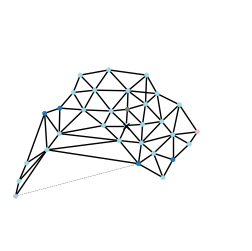

In [16]:
i = 0
j = 1234

plt.figure(figsize=(3, 3))
dataset.plot_subgraph(i, j)
plt.axis('off')

<br/><br/><br/><br/>

During training, due to the high throughput of data streaming, on-the-fly calculation of subgraph might be slow. To speed up data loading, we will save all subgraphs to chunk files first and load them during training/inference.

In [11]:
from tqdm import tqdm
tqdm(dataset.save_all_subgraphs_to_chunk())

0it [00:00, ?it/s]

In [17]:
import time

dataset.clear_cache()
dataset.set_subgraph_source('on-the-fly') # Can also be set through the `subgraph_source` argument
t0 = time.time()
for _ in range(5000):
    d = dataset[0]
t1 = time.time()
print("Sampling 5000 subgraphs on-the-fly took %.2f seconds" % (t1 - t0))

dataset.clear_cache()
dataset.set_subgraph_source('chunk_save')  
t0 = time.time()
for _ in range(5000):
    d = dataset[0]
t1 = time.time()
print("Loading 5000 subgraphs from chunk save took %.2f seconds" % (t1 - t0))


Sampling 5000 subgraphs on-the-fly took 18.01 seconds
Loading 5000 subgraphs from chunk save took 6.83 seconds


<br/><br/><br/><br/>

Transformers will be used to mask features, add node-level and graph-level tasks, etc.

In [18]:
transformers = [
    # `AddCenterCellType` will add `node_y` attribute to the subgraph for node-level prediction task
    # In this task we will mask the cell type of the center cell and use its neighborhood to predict the true cell type
    spacegm.AddCenterCellType(dataset),
    # `AddGraphLabel` will add `graph_y` and `graph_w` attributes to the subgraph for graph-level prediction task
    spacegm.AddGraphLabel(graph_label_file, tasks=['RESPONSE_ABBREV']),
    # Transformer `FeatureMask` will zero mask all feature items not included in its argument
    # In this tutorial we perform training/inference using cell types and center cell's size feature
    spacegm.FeatureMask(dataset, use_center_node_features=intensities, use_neighbor_node_features=intensities),
]

dataset.set_transforms([])  # No transformation
d1 = dataset[0]

dataset.set_transforms(transformers)
d2 = dataset[0]

<br/><br/>
`d1.x` has a full feature matrix, while `d2.x` only has the first column (for cell types) populated, except for its center cell, which has an additional feature of size.

(`d1` and `d2` are different subgraphs due to the random sampling)

In [19]:
print("\nFeatures of `d1`")
display(d1.x)
print("\nFeatures of `d2`")
display(d2.x)
print("\nCenter cell feature of `d2`")
display(d2.x[d2.center_node_index])


Features of `d1`


tensor([[ 0.0000e+00,  4.9861e-01,  4.0243e-01,  ...,  3.0000e-01,
          1.3604e+03, -5.0718e+02],
        [ 0.0000e+00,  1.8254e-01,  1.9345e-01,  ...,  0.0000e+00,
          1.3789e+03, -6.1735e+02],
        [ 1.9000e+01,  5.4473e-01,  4.2064e-01,  ...,  0.0000e+00,
          1.3821e+03, -6.2350e+02],
        ...,
        [ 1.9000e+01,  7.7602e-01,  7.7425e-01,  ...,  2.0000e-01,
          1.3249e+03, -6.0475e+02],
        [ 1.9000e+01,  6.4341e-01,  1.7183e-01,  ...,  0.0000e+00,
          1.3416e+03, -6.1237e+02],
        [ 1.9000e+01,  7.6551e-01,  5.0549e-01,  ...,  1.0000e-01,
          1.3273e+03, -6.1471e+02]], dtype=torch.float64)


Features of `d2`


tensor([[0., 0., 0.,  ..., 0., 0., -0.],
        [0., 0., 0.,  ..., 0., 0., -0.],
        [0., 0., 0.,  ..., 0., 0., -0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., -0.],
        [0., 0., 0.,  ..., 0., 0., -0.],
        [0., 0., 0.,  ..., 0., 0., -0.]], dtype=torch.float64)


Center cell feature of `d2`


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., -0.], dtype=torch.float64)

<br/><br/>

Note that d2 has additional attributes: `d2.node_y`, `d2.graph_y`, `d2.graph_w`

In [20]:
display(d1)
display(d2)

Data(x=[46, 50], edge_index=[2, 228], edge_attr=[228, 2], center_node_index=21, original_center_node=1695, num_nodes=46, region_id='df_0_1_1', component_id=0)

Data(x=[31, 50], edge_index=[2, 152], edge_attr=[152, 2], center_node_index=23, original_center_node=3454, num_nodes=31, region_id='df_0_1_1', component_id=0, node_y=[1], graph_y=[1, 1], graph_w=[1, 1])

<br/><br/><br/><br/>

------

### Step 3 Initialize a Graph Neural Network (GNN)

Now we construct a graph neural network for predicting `survival_status`.

The graph neural network will be composed of 3 parts:
1. The backbone GNN with specified number of graph convolutional layers
2. A node task prediction module if there are node-level tasks defined, this module will be constructed based on the node embedding of the center node
3. A graph task prediction module if there are graph-level tasks defined, this module will be constructed based on the graph-pooled embedding of all the nodes

In [21]:
model_kwargs = {
    'num_layer': dataset.subgraph_size,  # same number of layers as number of hops in the subgraphs
    'num_node_type': len(dataset.cell_type_mapping) + 1,  # number of embeddings for different cell types (plus one placeholder cell type)
    'num_feat': dataset[0].x.shape[1] - 1,  # exclude the cell type column
    'emb_dim': 512, 
    'num_node_tasks': len(dataset.cell_type_mapping),  # A multi-class classification task: predicting center cell type
    'num_graph_tasks': 1,  # a binary classification task
    'node_embedding_output': 'last', 
    'drop_ratio': 0.25, 
    'graph_pooling': "max", 
    'gnn_type': 'gin',
}

model = spacegm.GNN_pred(**model_kwargs)
device = 'cpu'

display(model)

GNN_pred(
  (gnn): GNN(
    (x_embedding): Embedding(22, 512)
    (feat_embedding): Linear(in_features=49, out_features=512, bias=True)
    (gnns): ModuleList(
      (0-2): 3 x GINConv()
    )
    (batch_norms): ModuleList(
      (0-2): 3 x BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (graph_pred_module): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
  (node_pred_module): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=21, bias=True)
  )
)

<br/><br/><br/><br/>

------

### Step 4 Train the GNN

GNNs in SPACE-GM are trained using n-hop subgraphs, see `data.SubgraphSampler` for details.

In this tutorial we specified one node-level task (predicting center cell type) and one graph-level task (predicting binary survival status), each task will have a specific loss function.


In [23]:
train_kwargs = {
    'batch_size': 64,
    'lr': 0.001,
    'graph_loss_weight': 1.0,  # Weight of graph task loss relative to node task loss
    'num_iterations': 50,  # In this demo we only train for 50 iterations/batches

    # Loss functions
    'node_task_loss_fn': nn.CrossEntropyLoss(),
    'graph_task_loss_fn': spacegm.models.BinaryCrossEntropy(),    

    # Evaluation during training
    'evaluate_fn': [spacegm.train.evaluate_by_sampling_subgraphs, spacegm.train.evaluate_by_full_graph, spacegm.train.save_model_weight],
    'evaluate_freq': 10,  # Evaluate the model every 10 iterations
}

<br/><br/>

On-the-fly evaluation of model performances is included in the training pipeline:

In [26]:
evaluate_kwargs = {
    'node_task_evaluate_fn': spacegm.inference.cell_type_prediction_evaluate_fn,
    'graph_task_evaluate_fn': spacegm.inference.graph_classification_evaluate_fn,
    'full_graph_node_task_evaluate_fn': spacegm.inference.full_graph_cell_type_prediction_evaluate_fn,
    'full_graph_graph_task_evaluate_fn': spacegm.inference.full_graph_graph_classification_evaluate_fn,
    'num_eval_iterations': 10,
    'score_file': os.path.join(model_save_root, 'GIN-example.txt'),
    'model_folder': os.path.join(model_save_root, 'GIN-example'),
}
train_kwargs.update(evaluate_kwargs)

<br/><br/>

Run training:

In [27]:
model = spacegm.train.train_subgraph(
    model, 
    dataset,
    device,
    # train_inds=[0, 1, 2, 3],
    # valid_inds=[0, 1, 2, 3],
    **train_kwargs)

Finished iterations 10
Finished iterations 20
Finished iterations 30
Finished iterations 40


<br/><br/>

Evaluation metrics during training are saved in the specified score file:

In [28]:
with open(evaluate_kwargs['score_file'], 'r') as f:
    for line in f.readlines():
        print(line)

Eval-Subgraph,Train,node-score,0.052,0.050,0.152,0.306,graph-score,0.472

Eval-Full-Graph,Train,node-score,0.036,0.034,0.077,0.512,graph-score,0.408

Eval-Subgraph,Train,node-score,0.057,0.056,0.155,0.255,graph-score,0.536

Eval-Full-Graph,Train,node-score,0.040,0.022,0.048,0.094,graph-score,0.379

Eval-Subgraph,Train,node-score,0.059,0.072,0.180,0.270,graph-score,0.471

Eval-Full-Graph,Train,node-score,0.097,0.199,0.241,0.251,graph-score,0.459

Eval-Subgraph,Train,node-score,0.045,0.041,0.152,0.234,graph-score,0.501

Eval-Full-Graph,Train,node-score,0.031,0.009,0.229,0.235,graph-score,0.544



<br/><br/>

Intermediate model weights are saved in the specified model folder:

In [29]:
print(os.listdir(evaluate_kwargs['model_folder']))

['model_save_0.pt', 'model_save_2.pt', 'model_save_3.pt', 'model_save_1.pt']


<br/><br/><br/><br/>

------

### Step 5 Evaluate the GNN

As GNNs are trained using subgraphs, there are two ways for evaluation (especially for graph-level tasks):

- Sample subgraphs and calculate metrics by treating each subgraph as an independent data point;
- Iterate over all the subgraphs (cells) of each region and calculate metrics, for graph-level tasks treat the aggregated (average) prediction from a region as an independent data point;

This is also reflected in the on-the-fly evaluation above: `spacegm.train.evaluate_by_sampling_subgraphs` and `spacegm.train.evaluate_by_full_graph`.

Here we demonstrate the two types of evaluation:

In [30]:
# Evaluation by iterating over the full graph
node_preds, graph_preds = spacegm.inference.collect_predict_for_all_nodes(
    model, dataset, device, print_progress=True)

# Aggregated (average) predictions of each region
for i, pred in graph_preds.items():
    region_id = dataset[i].region_id
    predicted_prob = 1 / (1 + np.exp(-np.array(pred)))  # Sigmoid
    avg_pred = np.mean(predicted_prob)
    print("On region %s, average prediction: %.3f" % (region_id, avg_pred))

spacegm.inference.full_graph_graph_classification_evaluate_fn(dataset, graph_preds, print_res=True)

predict on 0
predict on 1
predict on 2
predict on 3
predict on 4
predict on 5
predict on 6
predict on 7
predict on 8
predict on 9
predict on 10
predict on 11
predict on 12
predict on 13
predict on 14
predict on 15
predict on 16
predict on 17
predict on 18
predict on 19
predict on 20
predict on 21
predict on 22
predict on 23
predict on 24
predict on 25
predict on 26
predict on 27
predict on 28
predict on 29
predict on 30
predict on 31
predict on 32
predict on 33
predict on 34
predict on 35
predict on 36
predict on 37
predict on 38
predict on 39
predict on 40
predict on 41
predict on 42
predict on 43
predict on 44
predict on 45
predict on 46
predict on 47
predict on 48
predict on 49
predict on 50
predict on 51
predict on 52
predict on 53
predict on 54
predict on 55
predict on 56
predict on 57
predict on 58
predict on 59
predict on 60
predict on 61
predict on 62
predict on 63
predict on 64
predict on 65
predict on 66
predict on 67
predict on 68
predict on 69
predict on 70
predict on 71
pr

[0.5775492298693703]

In [31]:
# Evaluation by sampling subgraphs
node_preds, node_labels, graph_preds, graph_ys, graph_ws = spacegm.inference.collect_predict_by_random_sample(
    model, dataset, device, num_eval_iterations=50)
spacegm.inference.graph_classification_evaluate_fn(graph_preds, graph_ys, graph_ws)

GRAPH [0.47039267539488383]


[0.47039267539488383]